In [30]:
import csv

filename = "assignment_3_dataset.csv"

with open(filename, newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)  # Read the header row
    print("Headers:", header)
    
    # Print first 5 rows
    for i, row in enumerate(reader):
        print(row)
        if i == 4:  # Stop after 5 rows
            break

Headers: ['', 'person', 'lang', 'z1000t', 'z0t', 'z1000mem', 'stmtL', 'z1000rel', 'm1000rel', 'whours', 'caps']
['0', 's018', 'c', '0.017', '0.017', '22432', '16.1', '98.1', '96.8', '16.1', '??']
['1', 's030', 'C', '', '0.033', '16968', '4.0', '76.47', '92.1', '4.0', '??']
['2', 's036', 'c', '20.9', '0.0', '11440', '8.2', '0.0', '89.5', '8.2', '??']
['3', 's066', 'C', '0.75', '0.467', '2952', '7.3', '98.48', '100.0', '7.3', '??']
['4', 's078', 'c', '0.05', '0.05', '22496', '10.9', '99.24', '98.4', '10.9', '??']


In [31]:
import pandas as pd

df = pd.read_csv('assignment_3_dataset.csv')

# Display all rows nicely
from IPython.display import display
display(
    df.head(10).style.set_table_styles([
        {'selector': 'th', 'props': [('border', '1px solid black')]},
        {'selector': 'td', 'props': [('border', '1px solid gray')]}
    ])
)


,Unnamed: 0,person,lang,z1000t,z0t,z1000mem,stmtL,z1000rel,m1000rel,whours,caps
0,0,s018,c,0.017000,0.017000,22432,16.100000,98.100000,96.800000,16.100000,??
1,1,s030,C,nan,0.033000,16968,4.000000,76.470000,92.100000,4.000000,??
2,2,s036,c,20.900000,0.000000,11440,8.200000,0.000000,89.500000,8.200000,??
3,3,s066,C,0.750000,0.467000,2952,7.300000,98.480000,100.000000,7.300000,??
4,4,s078,c,0.050000,0.050000,22496,10.900000,99.240000,98.400000,10.900000,??
5,5,s015,c++,0.050000,0.050000,24616,11.200000,99.240000,100.000000,11.200000,??
6,6,s020,C++,1.983000,0.550000,6384,3.000000,98.480000,98.400000,3.000000,??
7,7,s021,c++,4.867000,0.017000,5312,nan,100.000000,98.400000,nan,??
8,8,s025,c++,0.083000,0.083000,28568,3.500000,99.240000,98.400000,3.500000,??
9,9,s027,c++,1.533000,0.000000,3472,25.300000,98.090000,100.000000,25.300000,??


## Functions
- Declare functions here - can be called in later cells
- ensure function cell has been run

In [32]:
# Function to color-code reliability values
def highlight_reliability(val):
    """Color-code reliability values based on performance ranges."""
    if pd.isna(val):
        return ''
    elif val < 10:
        return 'color: red; font-weight: bold;'
    elif val < 25:
        return 'color: orange;'
    elif val < 50:
        return 'color: goldenrod;'
    elif val < 90:
        return 'color: lightgreen;'
    elif val <= 100:
        return 'color: green; font-weight: bold;'
    else:
        return ''

## Missing Values
- Columns with missing values: ...
- Decide how to handle them: drop rows, fill with mean/median, etc.

In [33]:
df.isna().sum()

Unnamed: 0    0
person        0
lang          0
z1000t        5
z0t           0
z1000mem      0
stmtL         3
z1000rel      0
m1000rel      0
whours        3
caps          2
dtype: int64

## Step 2: Data Cleaning

Before analyzing the dataset, it is important to ensure the data is complete and consistent. This step involves:

1. **Handling Missing Values**  
   - We check each column for missing values (`NaN`).  
   - Any rows with missing values are removed using `dropna()`.  
   - This ensures that calculations and visualizations are not affected by incomplete data.

2. **Creating a Cleaned Dataset**  
   - The cleaned dataset is stored in `df_clean`.  
   - We confirm that all missing values are removed by checking the sum of NaNs per column.


In [34]:
import numpy as np

# Drop 'Unnamed: 0' column if it exists

df_dropped = df.copy()

if 'Unnamed: 0' in df.columns:
    df_dropped = df.drop(columns=['Unnamed: 0'])

if 'caps' in df_dropped.columns:
    df_dropped = df_dropped.drop(columns=['caps'])

# Normalize the language names
df_dropped['lang'] = df_dropped['lang'].str.strip().str.lower()

# Drop rows with any NaN values
df_clean = df_dropped.dropna()

# Sort by 'lang' ascending and 'whours' descending
df_sorted = df_clean.sort_values(by=['lang', 'whours'], ascending=[True, False])

# Reorder columns with caps at the end
#df_sorted = df_sorted[['person', 'lang', 'z1000t', 'z0t', 'z1000mem', 'stmtL', 'whours', 'z1000rel', 'm1000rel', 'caps']]

# Compute the 98th percentile (cap value)
loc_cap = df_sorted['whours'].quantile(0.98)

# Create a mask for rows below or equal to the cap
loc_mask = df_sorted['whours'] <= loc_cap

# Initialize Hours_std as NaN
df_sorted['Hours_std'] = np.nan

# Clip Hours values at the cap (optional, for display or further analysis)
df_sorted['Hours_cap'] = df_sorted['whours'].clip(upper=loc_cap)

# Standardize only the non-outlier rows
df_sorted.loc[loc_mask, 'Hours_std'] = (df_sorted.loc[loc_mask, 'Hours_cap'] - df_sorted.loc[loc_mask, 'Hours_cap'].mean()) / df_sorted.loc[loc_mask, 'Hours_cap'].std()

# Reorder columns without 'caps'
df_sorted = df_sorted[['person', 'lang', 'z1000t', 'z0t', 'z1000mem', 'stmtL', 'whours','Hours_std', 'z1000rel', 'm1000rel']]

# Rename columns for clarity
df_renamed = df_sorted.rename(columns={
    'person': 'ID',
    'lang': 'language',
    'z1000t': 'run_z1000_time',
    'z0t': 'run_z0_time',
    'stmtL': 'LOC',
    'z1000mem': 'mem_z1000_kb',
    'whours': 'hours',
    'caps': 'self_rated'
})

# Limit displayed decimal places to 2
pd.options.display.float_format = "{:.2f}".format

# Identify numeric columns
numeric_cols = df_renamed.select_dtypes(include='number').columns

# Print row counts before and after cleaning
print("Original rows:", len(df))
print("Rows after dropping NaNs:", len(df_renamed))


# Display cleaned DataFrame
from IPython.display import display
display(
    df_renamed
    .style.format({col: "{:.2f}" for col in numeric_cols})
    # Highlight 'z1000rel' and 'm1000rel' columns with color-coding based on reliability
    .map(highlight_reliability, subset=['z1000rel', 'm1000rel'])
    .set_table_styles([
        {'selector': 'th', 'props': [('border', '1px solid black')]},
        {'selector': 'td', 'props': [('border', '1px solid gray')]}
    ])
)


Original rows: 80
Rows after dropping NaNs: 73


,ID,language,run_z1000_time,run_z0_time,mem_z1000_kb,LOC,hours,Hours_std,z1000rel,m1000rel
0,s018,c,0.02,0.02,22432.00,16.10,16.10,0.67,98.10,96.80
4,s078,c,0.05,0.05,22496.00,10.90,10.90,0.19,99.24,98.40
2,s036,c,20.90,0.00,11440.00,8.20,8.20,-0.07,0.00,89.50
3,s066,c,0.75,0.47,2952.00,7.30,7.30,-0.15,98.48,100.00
9,s027,c++,1.53,0.00,3472.00,25.30,25.30,1.53,98.09,100.00
14,s090,c++,1.67,0.03,4152.00,19.60,19.60,1.00,98.48,100.00
13,s051,c++,0.15,0.03,3448.00,15.20,15.20,0.59,100.00,98.40
12,s042,c++,0.03,0.03,22680.00,11.90,11.90,0.28,100.00,100.00
5,s015,c++,0.05,0.05,24616.00,11.20,11.20,0.21,99.24,100.00
10,s033,c++,0.03,0.03,23336.00,10.10,10.10,0.11,99.24,98.40


# Exploratory Data Analysis
- Calculate and present descriptive statistics 
- Visualize distributions of key variables.
- Describe any anomalies or potential biases in the data.

In [35]:
df_sorted_top_hours = df_clean.sort_values(by=['whours'], ascending=[False])

display(df_sorted_top_hours.head(10))

,person,lang,z1000t,z0t,z1000mem,stmtL,z1000rel,m1000rel,whours
28,s060,java,3.78,0.10,29432,131342.00,98.85,96.30,131342.00
33,s072,java,30.10,0.07,52272,43637.00,100.00,100.00,43637.00
23,s053,java,0.27,0.10,52376,63.20,99.62,10.20,63.20
16,s017,java,0.63,0.43,41952,48.90,100.00,10.20,48.90
31,s065,java,1.47,0.12,49704,39.70,100.00,97.90,39.70
34,s081,java,0.20,0.15,79544,26.60,100.00,10.20,26.60
9,s027,c++,1.53,0.00,3472,25.30,98.09,100.00,25.30
36,s087,java,0.27,0.08,39896,19.70,100.00,100.00,19.70
14,s090,c++,1.67,0.03,4152,19.60,98.48,100.00,19.60
25,s056,java,0.35,0.07,22328,18.10,100.00,100.00,18.10


In [36]:
numeric_cols = df_renamed.select_dtypes(include='number').drop(columns=['Hours_std']).columns

# Descriptive statistics
for lang in df_renamed['language'].unique():
    print(f"Descriptive statistics for language: {lang}")
    lang_df = df_renamed[df_renamed['language'] == lang]
    descriptive_count = lang_df[numeric_cols].agg(['count']).iloc[0, 0]  # Extract only the first value
    print("Count:", descriptive_count)  # Print the count directly
    descriptive_stats = lang_df[numeric_cols].agg(['mean', 'min', 'max'])
    display(descriptive_stats)



Descriptive statistics for language: c
Count: 4


,run_z1000_time,run_z0_time,mem_z1000_kb,LOC,hours,z1000rel,m1000rel
mean,5.43,0.13,14830.00,10.62,10.62,73.95,96.17
min,0.02,0.00,2952.00,7.30,7.30,0.00,89.50
max,20.90,0.47,22496.00,16.10,16.10,99.24,100.00


Descriptive statistics for language: c++
Count: 10


,run_z1000_time,run_z0_time,mem_z1000_kb,LOC,hours,z1000rel,m1000rel
mean,2.78,0.09,12876.00,11.42,11.42,89.28,89.47
min,0.03,0.00,3448.00,3.00,3.00,0.00,1.10
max,21.40,0.55,28568.00,25.30,25.30,100.00,100.00


Descriptive statistics for language: java
Count: 24


,run_z1000_time,run_z0_time,mem_z1000_kb,LOC,hours,z1000rel,m1000rel
mean,5.94,0.26,48933.33,7305.07,7305.07,91.88,50.38
min,0.15,0.00,22328.00,0.00,0.00,0.18,6.60
max,37.10,2.02,89664.00,131342.00,131342.00,100.00,100.00


Descriptive statistics for language: perl
Count: 12


,run_z1000_time,run_z0_time,mem_z1000_kb,LOC,hours,z1000rel,m1000rel
mean,7.62,0.23,29164.00,3.15,3.15,91.48,83.07
min,0.08,0.07,17224.00,1.00,1.00,0.00,0.00
max,67.50,0.43,73448.00,7.00,7.00,100.00,100.00


Descriptive statistics for language: python
Count: 12


,run_z1000_time,run_z0_time,mem_z1000_kb,LOC,hours,z1000rel,m1000rel
mean,6.43,0.35,16153.33,3.21,3.21,99.68,76.43
min,0.08,0.07,13632.00,1.50,1.50,99.24,0.00
max,72.30,1.37,22608.00,5.50,5.50,100.00,100.00


Descriptive statistics for language: rexx
Count: 3


,run_z1000_time,run_z0_time,mem_z1000_kb,LOC,hours,z1000rel,m1000rel
mean,15.74,0.72,17088.00,6.31,6.31,81.46,81.30
min,0.82,0.30,8968.00,0.93,0.93,44.75,46.60
max,25.40,0.95,21152.00,10.00,10.00,100.00,98.90


Descriptive statistics for language: tcl
Count: 8


,run_z1000_time,run_z0_time,mem_z1000_kb,LOC,hours,z1000rel,m1000rel
mean,29.53,0.64,29662.00,4.72,4.72,100.00,88.78
min,0.47,0.37,17672.00,0.60,0.60,100.00,10.20
max,202.80,1.43,48840.00,13.00,13.00,100.00,100.00


In [37]:
import sys
print(sys.executable)


/usr/bin/python3


📈 Pearson Correlation Matrix:


,run_z1000_time,run_z0_time,mem_z1000_kb,LOC,hours,Hours_std,z1000rel,m1000rel
run_z1000_time,1.00,0.16,0.08,0.01,0.01,-0.06,-0.06,-0.18
run_z0_time,0.16,1.00,0.02,-0.09,-0.09,-0.12,-0.01,0.04
mem_z1000_kb,0.08,0.02,1.00,0.04,0.04,0.20,-0.19,-0.29
LOC,0.01,-0.09,0.04,1.00,1.00,1.00,0.04,0.09
hours,0.01,-0.09,0.04,1.00,1.00,1.00,0.04,0.09
Hours_std,-0.06,-0.12,0.20,1.00,1.00,1.00,0.06,-0.24
z1000rel,-0.06,-0.01,-0.19,0.04,0.04,0.06,1.00,0.24
m1000rel,-0.18,0.04,-0.29,0.09,0.09,-0.24,0.24,1.00



📈 Spearman Correlation Matrix:


,run_z1000_time,run_z0_time,mem_z1000_kb,LOC,hours,Hours_std,z1000rel,m1000rel
run_z1000_time,1.00,0.37,0.06,0.09,0.09,0.03,-0.11,-0.31
run_z0_time,0.37,1.00,0.10,-0.30,-0.30,-0.28,-0.01,0.05
mem_z1000_kb,0.06,0.10,1.00,0.23,0.23,0.20,0.23,-0.28
LOC,0.09,-0.30,0.23,1.00,1.00,1.00,-0.16,-0.24
hours,0.09,-0.30,0.23,1.00,1.00,1.00,-0.16,-0.24
Hours_std,0.03,-0.28,0.20,1.00,1.00,1.00,-0.15,-0.27
z1000rel,-0.11,-0.01,0.23,-0.16,-0.16,-0.15,1.00,0.12
m1000rel,-0.31,0.05,-0.28,-0.24,-0.24,-0.27,0.12,1.00


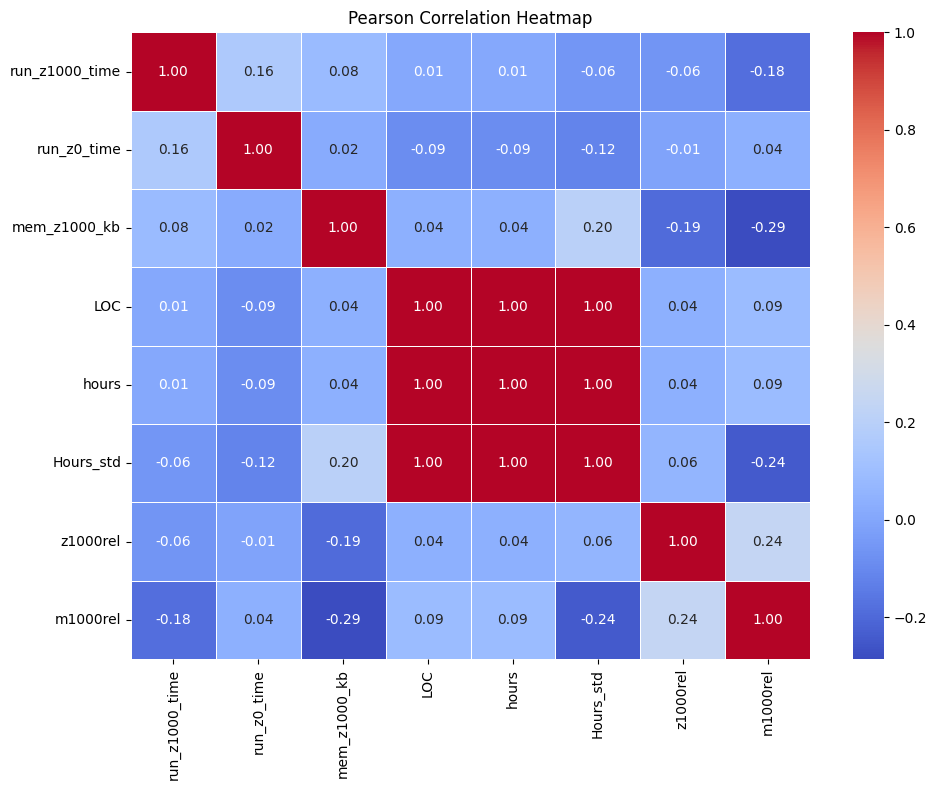

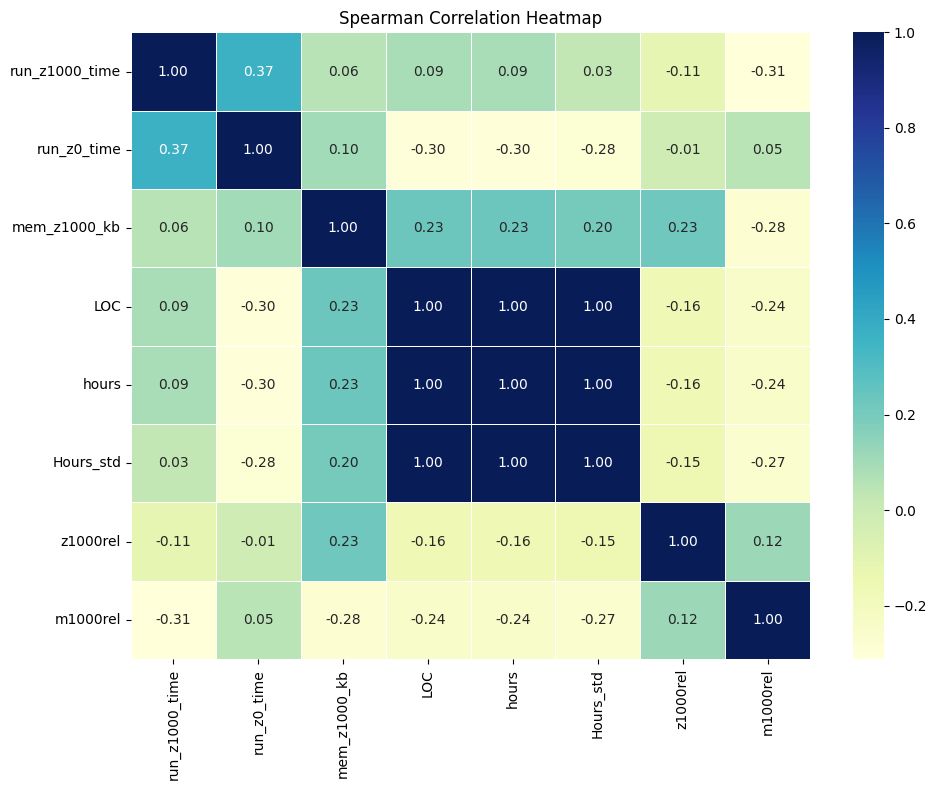

🔎 Top Pearson correlations with 'hours':


Hours_std      1.00
LOC            1.00
m1000rel       0.09
z1000rel       0.04
mem_z1000_kb   0.04
Name: hours, dtype: float64

🔎 Top Spearman correlations with 'hours':


LOC               1.00
Hours_std         1.00
mem_z1000_kb      0.23
run_z1000_time    0.09
z1000rel         -0.16
Name: hours, dtype: float64


📝 Interpretation:
- 'Hours_std' has a Pearson correlation of 1.00 with 'hours', indicating a strong positive linear relationship.
- 'LOC' has a Pearson correlation of 1.00 with 'hours', suggesting a positive trend as well.
- Spearman shows 'LOC' also has a rank correlation of 1.00, meaning the relationship holds even when considering monotonic (not strictly linear) trends.


In [38]:
# ===== Correlation Analysis =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns only for correlation
numeric_cols = df_renamed.select_dtypes(include='number').columns
df_numeric = df_renamed[numeric_cols]

# 1. 📊 Compute Pearson and Spearman correlation matrices
corr_pearson = df_numeric.corr(method='pearson')
corr_spearman = df_numeric.corr(method='spearman')

print("📈 Pearson Correlation Matrix:")
display(corr_pearson.round(2))

print("\n📈 Spearman Correlation Matrix:")
display(corr_spearman.round(2))

# 2. 🌡️ Visualize Pearson correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Heatmap')
plt.tight_layout()
plt.show()

# 3. 🌡️ Visualize Spearman correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_spearman, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Heatmap')
plt.tight_layout()
plt.show()

# 4. 🧠 Interpretation of interesting relationships
# Sort strongest correlations with 'hours' (excluding self-correlation)
pearson_hours = corr_pearson['hours'].drop('hours').sort_values(ascending=False)
spearman_hours = corr_spearman['hours'].drop('hours').sort_values(ascending=False)

print("🔎 Top Pearson correlations with 'hours':")
display(pearson_hours.head(5))

print("🔎 Top Spearman correlations with 'hours':")
display(spearman_hours.head(5))

# Example interpretation (can be adapted based on actual numbers)
# We’ll pick top 2 correlated features and print a short narrative.
top1 = pearson_hours.index[0]
top2 = pearson_hours.index[1]
val1 = pearson_hours.iloc[0]
val2 = pearson_hours.iloc[1]

print("\n📝 Interpretation:")
print(f"- '{top1}' has a Pearson correlation of {val1:.2f} with 'hours', indicating a strong {'positive' if val1>0 else 'negative'} linear relationship.")
print(f"- '{top2}' has a Pearson correlation of {val2:.2f} with 'hours', suggesting a {'positive' if val2>0 else 'negative'} trend as well.")

# (Optional) Check Spearman for ranking relationship
top_spearman = spearman_hours.index[0]
val_spear = spearman_hours.iloc[0]
print(f"- Spearman shows '{top_spearman}' also has a rank correlation of {val_spear:.2f}, meaning the relationship holds even when considering monotonic (not strictly linear) trends.")
